## Table of contents
### - [Introduction](#Introduction)
### - [Setup](#Setup)
### - [Example image](#Example-image)
### - [Automatic mask generation](#Automatic-mask-generation)
### - [Automatic mask generation options](#Automatic-mask-generation-options)
### - [Classification model](#Classification-model)
### - [Inference](#Inference)
### - [Gradio app](#Gradio-app)
### - [References](#References)
### - [Limitations](#Limitations)

## Introduction

In this notebook, I will combine Meta's segmentation model called **`SAM`** (Segment Anything Model) with a pretrained image classification model from the timm library to create a simple Gradio app. This app will categorize the objects found in an input image.

A significant portion of the code and explanations presented here has been replicated and adapted from the sources detailed in the [References](#References) section.

The purpose of this modest project is solely to experiment, learn, and practice.

## Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import sys
!{sys.executable} -m pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
import torch
print("CUDA is available:", torch.cuda.is_available())
import timm
!pip install -q gradio
import requests

!mkdir images
!wget -q -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_4b8939.pth

CUDA is available: True


In [2]:
for dirname, _, filenames in os.walk('/kaggle/working/'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        image_path = os.path.join(dirname, filename)

In [3]:
image_path

'/kaggle/working/images/dog.jpg'

In [4]:
sam_model_path = '../input/segment-anything/pytorch/vit-b/1/model.pth'

In [5]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Example image

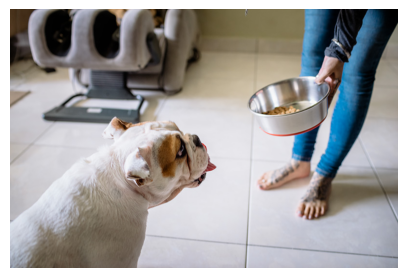

In [6]:
image = Image.open(image_path)
image = np.array(image.convert("RGB"))
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [7]:
# import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = sam_model_path
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device);

# mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [8]:
# masks = mask_generator.generate(image)

Show all the masks overlayed on the image

In [9]:
# plt.figure(figsize=(5,5))
# plt.imshow(image)
# show_anns(masks)
# plt.axis('off')
# plt.show() 

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [8]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [9]:
masks2 = mask_generator_2.generate(image)

In [10]:
len(masks2)

63

In [11]:
masks2[0].keys()

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])

Show all the masks overlayed on the image

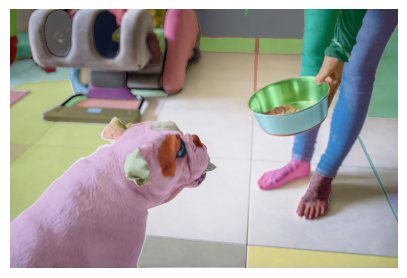

In [12]:
plt.figure(figsize=(5,5))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()

Show the dog mask in isolation, with dark background

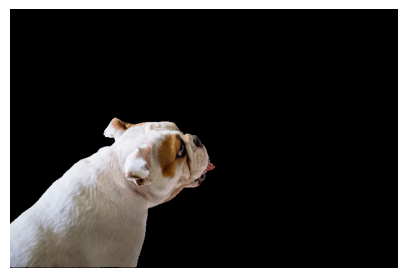

In [13]:
mask = np.where(masks2[23]['segmentation'], 1, 0)
new_image = image * np.expand_dims(mask, axis=-1)
plt.figure(figsize=(5,5))
plt.imshow(new_image)
plt.axis('off')
plt.show()

Show each mask separately

In [16]:
# for i in range(len(masks2)):
#     print(i)
#     mask = np.where(masks2[i]['segmentation'], 1, 0)
#     new_image = image * np.expand_dims(mask, axis=-1)
#     plt.figure(figsize=(5,5))
#     plt.imshow(new_image)
#     plt.axis('off')
#     plt.show()

Function to determine whether a mask belongs to a greater one

In [17]:
def is_part_of(mask1, mask2):
    mask1, mask2 = mask1.flatten(), mask2.flatten()
    # True if mask1 is entirely contained within mask2
    if np.any(mask1 & ~mask2):
        return False
    # True if both masks are NOT identical    
    if np.count_nonzero(mask1)==np.count_nonzero(mask2):
        return False
    return True


# check objects belonging to mask23

for i in range(len(masks2)):
    if is_part_of(masks2[i]['segmentation'], masks2[23]['segmentation']):
        print(f"Mask {i} is part of mask23")


# check if mask21 belongs to another mask

for i in range(len(masks2)):
    if is_part_of(masks2[21]['segmentation'], masks2[i]['segmentation']):
        print(f"Mask 21 is part of mask {i}.")

Mask 21 is part of mask23
Mask 25 is part of mask23
Mask 49 is part of mask23
Mask 21 is part of mask 23.


## Classification model

In [18]:
# timm.list_models('*huge*in1k*', pretrained=True)

Chose model blablabla because blablabla

In [14]:
cv_model = timm.create_model('convnext_small.in12k_ft_in1k_384', pretrained=True).eval()
transform = timm.data.create_transform(
    **timm.data.resolve_data_config(cv_model.pretrained_cfg)
)
transform;
# 86.182	97.92	384---	50.22	25.58	63.37	516.19	256

Compose(
    Resize(size=(384, 384), interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(384, 384))
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

Apply transform to image prior to inference

In [16]:
pil_image = Image.fromarray(new_image.astype(np.uint8))
image_tensor = transform(pil_image)

Show transformed image

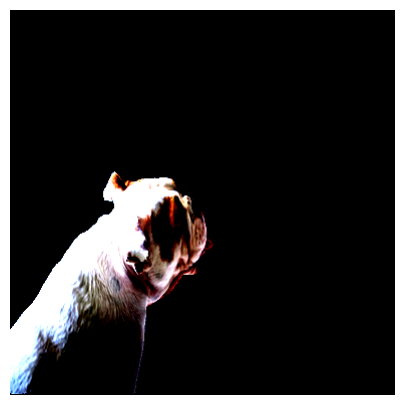

In [18]:
plt.figure(figsize=(5,5))
plt.imshow(np.transpose(image_tensor, (1,2,0)))
plt.axis('off')
plt.show()

## Inference

In [19]:
with torch.no_grad():
    output = cv_model(image_tensor.unsqueeze(0))
output.shape

torch.Size([1, 1000])

In [20]:
probabilities = torch.nn.functional.softmax(output[0], dim=0)
probabilities.shape

torch.Size([1000])

In [21]:
values, indices = torch.topk(probabilities, 3)
indices

tensor([242, 179, 245])

Obtain labels from the `IMAGENET_1k` dataset

In [22]:
IMAGENET_1k_URL = 'https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt'
IMAGENET_1k_LABELS = requests.get(IMAGENET_1k_URL).text.strip().split('\n')
print('The 3 most likely labels for the given picture are:', '\n')
[{'label': IMAGENET_1k_LABELS[idx], 'value': np.round(val.item()*100, 2)} for val, idx in zip(values, indices)]

The 3 most likely labels for the given picture are: 



[{'label': 'boxer', 'value': 25.06},
 {'label': 'Staffordshire_bullterrier, Staffordshire_bull_terrier',
  'value': 21.74},
 {'label': 'French_bulldog', 'value': 11.69}]

----------------------

## Gradio app

The following cell contains the majority of the code seen in the previous sections and can be executed independently.

In [6]:
# # setup
# import numpy as np
# import matplotlib.pyplot as plt
# from PIL import Image
# import torch
# import sys
# !{sys.executable} -m pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
# import timm
# import requests
# !pip install -q gradio
# import gradio as gr

# # automatic mask generation
# sam_model_path = '../input/segment-anything/pytorch/vit-b/1/model.pth'
# sys.path.append("..")
# from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
# sam_checkpoint = sam_model_path
# model_type = "vit_b"
# device = "cuda"
# sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# sam.to(device=device)

# mask_generator_2 = SamAutomaticMaskGenerator(
#     model=sam,
#     points_per_side=32,
#     pred_iou_thresh=0.86,
#     stability_score_thresh=0.92,
#     crop_n_layers=1,
#     crop_n_points_downscale_factor=2,
#     min_mask_region_area=100, 
# )

# # classification model
# cv_model = timm.create_model('convnext_small.in12k_ft_in1k_384', pretrained=True).eval()
# transform = timm.data.create_transform(
#     **timm.data.resolve_data_config(cv_model.pretrained_cfg)
# )

# # ImageNet labels
# IMAGENET_1k_URL = 'https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt'
# IMAGENET_1k_LABELS = requests.get(IMAGENET_1k_URL).text.strip().split('\n')

# closing active port connections
# gr.close_all();

# def simplify_masks(masks):
#     for mask in masks:
#         for i in range(6):
#             mask.popitem()
            
# def key(mask):
#     return mask['segmentation'].sum()
        
# def sort_masks_size(masks):
#     masks = sorted(masks, key=key, reverse=True)
#     return masks

# def predict(image):
#     masks2 = mask_generator_2.generate(image)
#     simplify_masks(masks2)
#     masks2 = sort_masks_size(masks2)
    
#     label_lst = []
#     for i in range(min(10, len(masks2))):
#         mask = masks2[i]['segmentation'].astype(np.uint8)
#         new_image = image * np.expand_dims(mask, axis=-1)
#         pil_image = Image.fromarray(new_image.astype(np.uint8))
#         image_tensor = transform(pil_image)
        
#         with torch.no_grad():
#             output = cv_model(image_tensor.unsqueeze(0))
        
#         probabilities = torch.nn.functional.softmax(output[0], dim=0)
#         value, idx = torch.topk(probabilities, 1)
        
#         if value>0.1:
#             label_lst.append(IMAGENET_1k_LABELS[idx].split(',')[0])
                
#     return f'The given picture probably contains the following items: {set(label_lst)}'

# gr.Interface(fn=predict, inputs='image', outputs='text').launch(share=True)

Closing server running on port: 7860
Closing server running on port: 7860
Closing server running on port: 7860
Closing server running on port: 7860
Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://221b475b7d54555863.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/gradio/routes.py", line 442, in run_predict
    output = await app.get_blocks().process_api(
  File "/opt/conda/lib/python3.10/site-packages/gradio/blocks.py", line 1390, in process_api
    inputs = self.preprocess_data(fn_index, inputs, state)
  File "/opt/conda/lib/python3.10/site-packages/gradio/blocks.py", line 1233, in preprocess_data
    processed_input.append(block.preprocess(inputs[i]))
  File "/opt/conda/lib/python3.10/site-packages/gradio/components/image.py", line 274, in preprocess
    im = processing_utils.decode_base64_to_image(x)
  File "/opt/conda/lib/python3.10/site-packages/gradio/processing_utils.py", line 59, in decode_base64_to_image
    img = Image.open(BytesIO(base64.b64decode(image_encoded)))
  File "/opt/conda/lib/python3.10/site-packages/PIL/Image.py", line 3298, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO obj

In [3]:
# # setup
# import numpy as np
# import matplotlib.pyplot as plt
# from PIL import Image
# import torch
# import sys
# !{sys.executable} -m pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
# import timm
# import requests
# !pip install -q gradio
# import gradio as gr

# # automatic mask generation
# sam_model_path = '../input/segment-anything/pytorch/vit-b/1/model.pth'
# sys.path.append("..")
# from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
# sam_checkpoint = sam_model_path
# model_type = "vit_b"
# device = "cuda"
# sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# sam.to(device=device)
# mask_generator = SamAutomaticMaskGenerator(sam)

# # classification model
# cv_model = timm.create_model('convnext_small.in12k_ft_in1k_384', pretrained=True).eval()
# transform = timm.data.create_transform(
#     **timm.data.resolve_data_config(cv_model.pretrained_cfg)
# )

# # ImageNet labels
# IMAGENET_1k_URL = 'https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt'
# IMAGENET_1k_LABELS = requests.get(IMAGENET_1k_URL).text.strip().split('\n')

# closing active port connections
gr.close_all();

def simplify_masks(masks):
    for mask in masks:
        for i in range(6):
            mask.popitem()
            
def key(mask):
    return mask['segmentation'].sum()
        
def sort_masks_size(masks):
    masks = sorted(masks, key=key, reverse=True)
    return masks

def predict(image):
    masks = mask_generator.generate(image)
    simplify_masks(masks)
    masks = sort_masks_size(masks)
    
    label_lst = []
    for i in range(min(10, len(masks))):
        mask = masks[i]['segmentation'].astype(np.uint8)
        new_image = image * np.expand_dims(mask, axis=-1)
        pil_image = Image.fromarray(new_image.astype(np.uint8))
        image_tensor = transform(pil_image)
        
        with torch.no_grad():
            output = cv_model(image_tensor.unsqueeze(0))
        
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        value, idx = torch.topk(probabilities, 1)
        
        if value>0.1:
            label_lst.append(IMAGENET_1k_LABELS[idx].split(',')[0])
                
    return f'The given picture probably contains the following items: {set(label_lst)}'

gr.Interface(fn=predict, inputs='image', outputs='text').launch(share=True)

Closing server running on port: 7860
Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://f34565d4a8b948f091.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


44
44
80


In [ ]:
# backlog
    # share True for gradio app to work?
    # review best practices for organizing imports
    # gradio - comments on predict function
    # imports, import sam model
    # group samples in batches according to batch size -256- comment out unsqueeze
    # url = 'https://www.closetfactory.com/wp-content/uploads/2020/01/shutterstock_1381069457.png'
            # 'image = Image.open(requests.get(url, stream=True).raw)'
    # explain timm model selection -model size-param_count https://huggingface.co/timm/convnext_small.in12k_ft_in1k_384
        # top1---	top5----	img_size	param_count	--samples_per_sec	batch_size
        # 86.182	97.92	----384---	------50.22	---------516--------	256

    # 10 biggest / most reliable objects
    # slider control to select 5 objects by size, certainty
    # object is part of another object...
    # obtain image and model automatically
    # decide sam model
    # citation for timm model and timm's r wightman
    # future work: ?
    # introduction - purpose this work experimentation, learning, practicing
    # limitations: Sam model, timm model, 1k classes imagenet. rubbish performance vs image to prompt models..diffusion..

In [ ]:
# caution

In [ ]:
# aux

# import pickle
        # with open(file_path, 'wb') as file:
            # pickle.dump(data, file)
        # with open(file_path, 'rb') as file:
            # loaded_data = pickle.load(file)
        # import io; # Serialize using BytesIO and pickle
            # buffer = io.BytesIO()
            # pickle.dump(data, buffer)

## References

- Segment Anything Model (`SAM`) by Meta
    - https://github.com/facebookresearch/segment-anything/blob/main/README.md

    - @article{kirillov2023segany,
  title={Segment Anything},
  author={Kirillov, Alexander and Mintun, Eric and Ravi, Nikhila and Mao, Hanzi and Rolland, Chloe and Gustafson, Laura and Xiao, Tete and Whitehead, Spencer and Berg, Alexander C. and Lo, Wan-Yen and Doll{\'a}r, Piotr and Girshick, Ross},
  journal={arXiv:2304.02643},
  year={2023}
}

- Timm Library
    - https://timm.fast.ai/
    - https://huggingface.co/docs/timm/quickstart

## Limitations